# Tutorial sample for FDpy
## ⚠️ Warning ⚠️: Running the same cell more than once might lead to some unexpected bheavior.
## Introduction
The purpose of the notebook is to give some exampls on how to use the library and explain some of the theory behind it. The library aims on solving most PDEs of the following form:
$$a_0+a_1U+a_2U_x+a_3U_{xx}+...=b_0+b_1U+b_2U_t+b3U_{tt}+...$$
Using an Implicit finite difference scheme. On a one dimensional domain (i.e. a line) of length L. The problem can be given boundary conditions of the following general form:
$$U(x=0)= c_1+c_2U(x=\Delta x)+c_3U(x=2\Delta x)+...$$
Where $c$ s are constants. Initial conditions can be defined in the same way.  
Note: The boundary conditions can only be specified at the start/end points (e.g. $U(x=0)$, $U(x=\Delta x)$ and $U(x=L)$ if 3 boundary conditions are needed). Also, initial conditions can only be specified at starting times.
Note: You might need an extension such as ipykernel to run the following notebook.
## Detailed Example
### Step 0: Install the Package

In [2]:
import sys  # This will take some time! FDpy depends on three other libraries.
!{sys.executable} -m pip install git+https://github.com/JadM133/FDpy.git  

### Step 1: Import the required class
The class Fd_problem defines the finite difference problem that we want to solve. This class will later include all the required information about the problem.

In [3]:
from FDpy.fd_problem import Fd_problem
import math
import numpy as np

ModuleNotFoundError: No module named 'matplotlib'

### Step 2: Define the problem to be solved
As an example, we will be solving the diffusion equation:  
$$U_{xx}=U_t$$
On a domain from 0 to 10. With the following boundary conditions:
$$U(x=0)=0,\qquad\qquad\qquad \frac{\partial U}{\partial x}(x=10)=0.$$ 
And the following initial condition:
$$U(t=0)=1.$$
Note that even though this will be the only detailed example, the code implementation of more complicated examples can be found in the end of the notebook.  
We will start by defining the problem in the following code:

In [3]:
domain = (0, 10)  # Define the line as a list containing start/end points respectively.
interval = (0, 2)  # Define the time interval on which we wish to solve the problem.

### Defining boundary conditions:
As previously mentioned, there is a lot of flexibility in specifying boundary conditions since they can depend on the values of inner nodes.   
General note: Unfortunately, boundary nodes can depend on inner nodes but **CAN NOT** depend on each others for now.  
The boundary conditions are specified in a list (in this case of length 2). Every entry of the list can either be a number, or a tuple which defines the equation associated with the boundary condition. For example, in our case the boundary condtions are defined as follows:

In [4]:
boundary = (0, (0, 1))

The first entry clearly specifies the first boundary condition ($U=0$ at $x=0$). The second one on the other hand means the following:
$$U(x=10)=0+1\times U(x=10-\Delta x)$$
Which is the same as the second boundary condition when we approximate the derivative using finite differences.
Note: Specifying a tuple for the left boundary conditions will imply dependences on inner nodes going from right to left (i.e. a constant, then $U(x=\Delta x)$, then $U(x=2\Delta x)$, ...). On the other hand, specifying a tuple for right boundary conditions will imply dependence on left inner points (i.e. a constant, then $U(x=10-\Delta x)$, then $U(x=10-2\Delta x)$, ...). Now the problem remains, how would the program know which boundary condition is to which node? Even though it is straight forward in this case (only two boundary conditions), we have to also specify a map for the boundary conditions to specify the positions of each value previously given.

In [5]:
bc_map = [0, -1]  # This means first BC is at the 0th element, and the second as at the last element.

### Defining Initial conditions
Initial conditions can be defined in multiple ways. Either integers (just one value), or a tuple (when initial conditions depend on **Each others**), a specifed function using the Expressions class (for an example check the last part of the notebook), or an array specifying values at every point in x.
Note: For now, initial conditions can only depend on each others and not on future nodes. In our case, we can simply define the initial condition as follows:

In [6]:
initial = [1]

### Defining the equation
The equation is defined by a list of two tuples (each specifying one part of the equation). A similar strategy as the one used to specify boundary conditions is used. In a certain tuple, the first entry multiplies a constant, the second multiplies $U$, the third multiplies the first derivative of $U$, then the second derivative, etc.. Accordingly, we define the diffusion equation as follows.

In [7]:
equation = [(0, 0, 0, 1), (0, 0, 1)]  # Uxx = Ut

### Remaining parameters
Lastly, we define the remaining parameters. These include the step size in both time and space, as well as the method we ould like to use to approximate the derivatives. The methods are specified by a list of two strings (first for space, second for time). The method included are center FD "cen", backward FD "bac", and forward FD "for".

In [8]:
dx = 0.1
dt = 0.1
method=["cen", "for"]

The choice of the method can be anything as long as the boundary conditions are the right ones. Sometimes, it is hard to know which boundary conditions should be specified. Alternatively, we created a function that helps in this matter! More details can be found in the rest of the notebook (function self.info()).  
Now we are finally ready to define the instance of the class.

In [9]:
prob = Fd_problem(domain, interval, equation, boundary, initial, dx, dt, method=["cen", "for"], bc_map=bc_map)

And that's actually it! Now the only thing we have to do is to run forward in time using the following function:

In [10]:
solution = prob.forward_in_time(acc_x=2, acc_t=1, verbose=True)  # We can specify required accuracy in space and time.

*******************Approximation*****************
Left hand side: (-2.0*U(i,j+1)+U(i+1,j+1)+U(i-1,j+1))/dx^2
Right hand side: (-1.0*U(i,j)+U(i,j+1))/dt^1
Where U(i, j) means at point x = i*delta x and t = j * delta t
Solving the matrix system for all times...
Done.


The solution is a matrix of shape X_points*t_points (each column is the solution at a specific time step).   
Note: The approximation is computed automatically following the algorythm presented by [1]. We only have to specify the type (i.e. center, forward, or backward), and the accuracy.
### Post processing
The library also contains some post-processing tool where the solution can be animated and compared to an actual solution (if it exists). Note that in this case the similarity solution is as follows:
$$y_{exact}=\mathrm{erf}\left(\frac{x}{2t^{0.5}}\right)$$

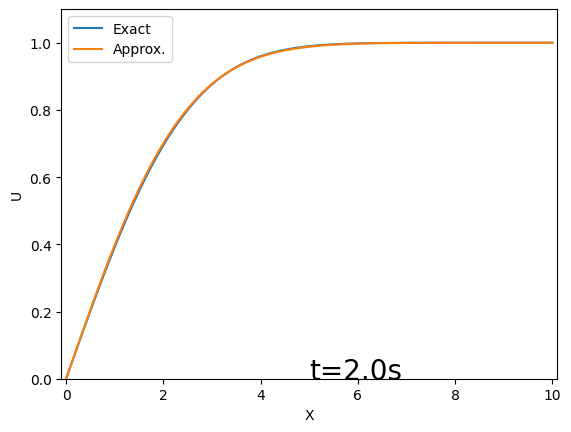

In [11]:
def func(x, t):
    return math.erf(x/(2*(t+0.00001)**0.5))

er = prob.post_process(solution, exact=func, save=True, jup=True, error=True)

Things to note:    
1- The last argument is to specify if jupyter notebook is running the process or not (do not specify it when running a script).      
2- The exact solution is optional. Not specifying an exact solution will simply plot the approximation.    
3- The GIF is also saved in the root directory if needed later.    
4- The output of the animation function is the error between the exact solution and the approximation (2-norm of the difference between the matrices). This can be seen below:

In [12]:
print(er)

0.35729166642982735


In this case, we don't expect the error to be of extremely small orders since we are comparing our approximation to a similarity solution (only valid for large times).

### Don't know which boundary/initial conditions to specify?
Since usually one would like to use different approximations with different accuracy, it is sometimes hard to keep track of which boundary conditions should be specified. Unfortunately, the choice can not be random (for more details read about method of characteristices). Accordingly, the user can define the Fd_problem instance without boundary and initial condition as follows.

In [13]:
prob2 = Fd_problem(domain=domain, interval=interval, equation=equation, dx=dx, dt=dt, method=["cen", "for"])

Then, we can request the library to tell us which boundary/initial conditions for specific accuracies in x and t as follows.

In [14]:
_ = prob2.info(acc_x=2, acc_t=1)

****************SUMMARY**************
Left hand side: (-2.0*U(i,j+1)+U(i+1,j+1)+U(i-1,j+1))/dx^2
with accuracy: 2
Right hand side: (-1.0*U(i,j)+U(i,j+1))/dt^1
with accuracy: 1
BC are needed at the following points from the right: [-1]
And these from the left: [0]
IC are needed at the following times: [0.]


The function self.info() gives a summary clearly stating the approximation used (the first index is for space and the second index is for time). It also tells us which boundary/initial conditions are needed. Clearly, in the case, we need two boundary conditions (one from the left, one from the right), and one initial condition for the accuracies specified.   
We can consequently add the boundary/initial conditions using the self.add() method and then solve the problem in the same way as before!

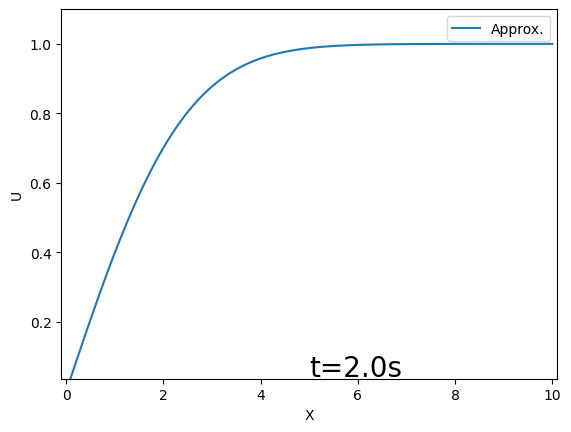

In [15]:
prob2.add(boundary=[0, (0, 1)], initial=[1], bc_map=[0, -1])
solution = prob2.forward_in_time(acc_x=2, acc_t=1, verbose=True)
er = prob2.post_process(solution, save=True, jup=True)

## Other examples
This section includes the code to solve some two other equations (transport and wave equations).
### Transport equation
$$U_x=2U_t$$
With the following boundary conditions:
$$U(x=0)=0, \quad\quad\quad\quad U(t=0)=\mathrm{exp}(-(x-3)^2)$$

In [16]:
domain = (0, 10)
interval = (0, 10)
equation = [(0, 0, 1), (0, 0, -1)]
dx = 0.1
dt = 0.1
problem3 = Fd_problem(domain=domain, interval=interval, equation=equation, dx=dx, dt=dt, method=["bac", "for"], method_fd="imp")
_ = problem3.info(acc_x=1, acc_t=1)  #Make sure the scheme we are using suits the boundary/initial conditions given

****************SUMMARY**************
Left hand side: (U(i,j+1)-1.0*U(i-1,j+1))/dx^1
with accuracy: 1
Right hand side: (U(i,j)-1.0*U(i,j+1))/dt^1
with accuracy: 1
BC are needed at the following points from the right: []
And these from the left: [0]
IC are needed at the following times: [0.]


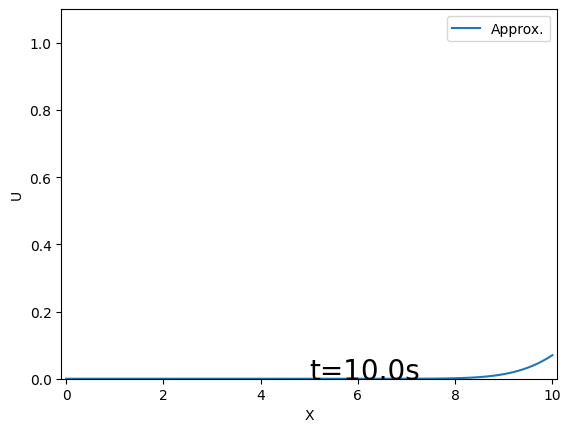

In [17]:
# Create a vector for all inner values to specify the initial condition
def init_func(x):
    return np.exp(-(x-3)**2)
x_vec = np.arange(domain[0], domain[1], dx)
func = np.vectorize(init_func)

problem3.add(boundary=[0], initial=[func(x_vec)], bc_map=[0])
solution = problem3.forward_in_time(acc_x=1, acc_t=1)
er = problem3.post_process(solution, save=True, jup=True)

Note: The diffusion that is happening is expected when implicit schemes are used. This is what we have to trade off for better stability! To resolve this, we can use an explicit scheme as follows.

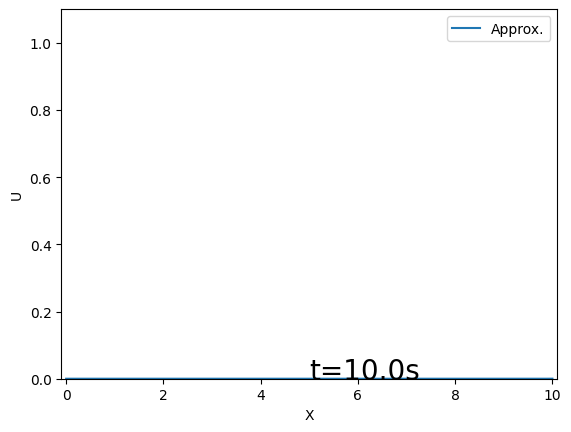

In [18]:
problem3_b = Fd_problem(domain=domain, interval=interval, equation=equation, dx=dx, dt=dt,
                      method=["bac", "for"], method_fd="exp", boundary=[0], initial=[func(x_vec)], bc_map=[0])
solution = problem3_b.forward_in_time(acc_x=1, acc_t=1)
er = problem3_b.post_process(solution, save=True, jup=True)

As we can see in the animation, the problem is solved! We have to be careful for stability though. The stap size in space squarred should be at least equatl to the step size in time (CFL number less then one). Otherwise, the explecit scheme suffers of stability issues.

### The wave equation
$$U_{xx}=U_{tt}$$
With the following boundary/initial conditions:
$$U(x=0)=0, \quad\quad U(x=10)=0, \quad\quad\quad\quad U(t=0)=\mathrm{exp}(-(x-5)^2), \quad\quad \frac{\partial U}{\partial x}(t=0)=0$$

In [19]:
domain = (0, 10)
interval = (0, 10)
equation = [(0, 0, 0, 1), (0, 0, 0, 1)]
dx = 0.1
dt = 0.1
problem4 = Fd_problem(domain=domain, interval=interval, equation=equation, dx=dx, dt=dt, method=["cen", "for"])
_ = problem4.info(acc_x=2, acc_t=1)

****************SUMMARY**************
Left hand side: (-2.0*U(i,j+2)+U(i+1,j+2)+U(i-1,j+2))/dx^2
with accuracy: 2
Right hand side: (U(i,j)-2.0*U(i,j+1)+U(i,j+2))/dt^2
with accuracy: 1
BC are needed at the following points from the right: [-1]
And these from the left: [0]
IC are needed at the following times: [0. 1.]


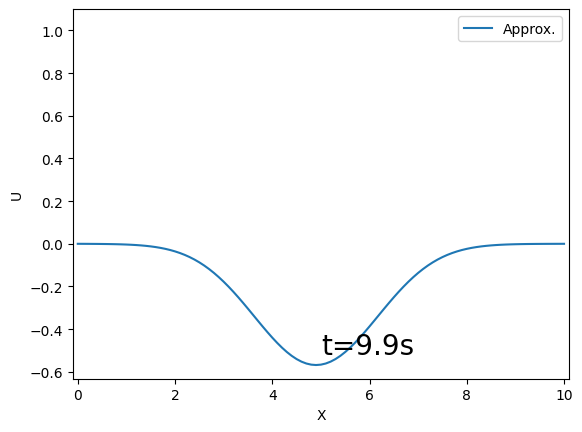

In [20]:
# Create a vector for all inner values to specify the initial condition
def init_func(x):
    return np.exp(-(x-5)**2)
x_vec = np.arange(domain[0], domain[1]-dx, dx) # Due to rounding, sometimes one less/more entries are needed.
func = np.vectorize(init_func)

problem4.add(boundary=[0, 0], initial=[func(x_vec), (0, 1)], bc_map=[0, -1])
solution = problem4.forward_in_time(acc_x=1, acc_t=1)
er = problem4.post_process(solution, save=True, jup=True)

Interesting isn't it? What would happen if we specify the boundary conditions to be homogeneous Neumann boundary conditions? It resembles a flow of water as can be seen below. (Note, the add function resets any boundary/initial conditions if already given before). We define a different initial condition using the Expressions class this time.

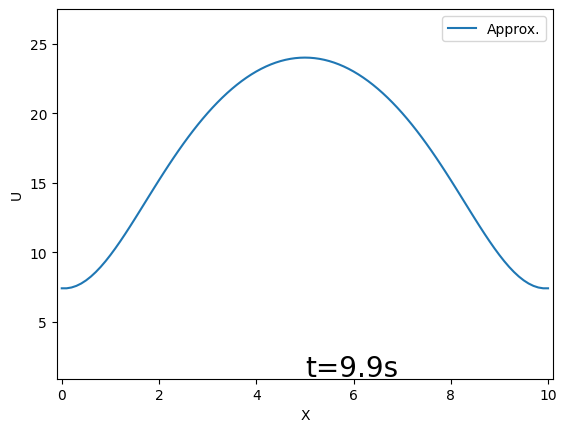

In [22]:
from FDpy.expressions import Symbol
x = Symbol('x')  # Symbol name always has to be x
func = -1*(x-5)**2+25
problem4.add(boundary=[(0, 1), (0, 1)], initial=[func, (0, 1)], bc_map=[0, -1])
solution = problem4.forward_in_time(acc_x=1, acc_t=1)
er = problem4.post_process(solution, save=True, jup=True)

<a id="1">[1]</a> 
Fornberg, Bengt. (1988). 
Generation of finite difference formulas on arbitrarily spaced grids. 
Mathematics of computation 51.184, p:699-706.